In [ ]:
import warnings
from matcalc.relaxation import RelaxCalc
from matcalc.phonon import PhononCalc
from matcalc.eos import EOSCalc
from matcalc.elasticity import ElasticityCalc
from matcalc.utils import get_universal_calculator
from tqdm import tqdm
from time import perf_counter

from mp_api.client import MPRester

warnings.filterwarnings("ignore", category=UserWarning, module="matgl")

In [ ]:
mp_data = MPRester().materials.search(
    num_sites=(1, 8), fields=["material_id", "structure"], num_chunks=1, chunk_size=100
)

Retrieving MaterialsDoc documents:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
models = [(name, get_universal_calculator(name)) for name in ("M3GNet", "CHGNet", "MACE")]

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps
Using Materials Project MACE for MACECalculator with /Users/janosh/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


In [ ]:
fmax = 0.1
opt = "BFGSLineSearch"

In [ ]:
prop_preds = []

for dct in (pbar := tqdm(mp_data[:10])):  # Here we just do a sampling of 20 structures.
    mat_id, formula = dct.material_id, dct.structure.formula
    pbar.set_description(f"Running {mat_id} ({formula})")
    model_preds = {"material_id": mat_id, "formula": formula, "nsites": len(dct.structure)}

    for model_name, model in models:
        # The general principle is to do a relaxation first and just reuse the same structure.
        prop_calcs = [
            ("relax", RelaxCalc(model, fmax=fmax, optimizer=opt)),
            ("elastic", ElasticityCalc(model, fmax=fmax, relax_structure=False)),
            ("eos", EOSCalc(model, fmax=fmax, relax_structure=False, optimizer=opt)),
            ("phonon", PhononCalc(model, fmax=fmax, relax_structure=False)),
        ]
        properties = {}
        for name, prop_calc in prop_calcs:
            start_time = perf_counter()
            properties[name] = prop_calc.calc(dct.structure)
            if name == "relax":
                # Replace the structure with the one from relaxation for other property computations.
                struct = properties[name]["final_structure"]
            model_preds[f"time_{name}_{model_name}"] = perf_counter() - start_time
        model_preds[model_name] = properties
    prop_preds.append(model_preds)

Processing mp-1185285 (Li1 Ac1 Hg2):   0%|          | 0/10 [00:00<?, ?it/s]/Users/janosh/dev/matcalc/matcalc/relaxation.py:131: FutureWarning: Import ExpCellFilter from ase.filters
  atoms = ExpCellFilter(atoms)
/Users/janosh/dev/matcalc/matcalc/relaxation.py:131: FutureWarning: Import ExpCellFilter from ase.filters
  atoms = ExpCellFilter(atoms)
/Users/janosh/dev/matcalc/matcalc/relaxation.py:131: FutureWarning: Import ExpCellFilter from ase.filters
  atoms = ExpCellFilter(atoms)
Processing mp-1183106 (Ac2 Zn1 In1):  10%|█         | 1/10 [00:08<01:17,  8.66s/it]/Users/janosh/dev/matcalc/matcalc/relaxation.py:131: FutureWarning: Import ExpCellFilter from ase.filters
  atoms = ExpCellFilter(atoms)
/Users/janosh/dev/matcalc/matcalc/relaxation.py:131: FutureWarning: Import ExpCellFilter from ase.filters
  atoms = ExpCellFilter(atoms)
/Users/janosh/dev/matcalc/matcalc/relaxation.py:131: FutureWarning: Import ExpCellFilter from ase.filters
  atoms = ExpCellFilter(atoms)
Processing mp-976333

In [ ]:
import pandas as pd

df_preds = pd.DataFrame(prop_preds)
for model_name, _ in models:
    df_preds[f"time_total_{model_name}"] = (
        df_preds[f"time_relax_{model_name}"]
        + df_preds[f"time_elastic_{model_name}"]
        + df_preds[f"time_phonon_{model_name}"]
        + df_preds[f"time_eos_{model_name}"]
    )

In [ ]:
df_preds

mid composition  nsites  time_relax_M3GNet  time_elastic_M3GNet  \
0   mp-1106268    Pr14 Pd6      20           5.038833             0.341546   
1    mp-974315      Ru2 I2       4           0.773536             0.179219   
2   mp-1206714     Al2 Sn1       3           0.167687             0.115795   
3     mp-30339     Er1 Ag2       3           0.103580             0.186156   
4       mp-696     Si4 Pt4       8           0.884884             0.321063   
5    mp-866222     Ac2 Si6       8           3.100128             0.253995   
6     mp-11422     Gd1 Hg1       2           0.078004             0.116329   
7     mp-21238     Th4 Si4       8           0.755927             0.203286   
8   mp-1215363     Zr4 Pd1       5           0.272751             0.206009   
9   mp-1212658      Ga1 C6       7           0.628700             0.237454   
10  mp-1101922     Eu4 Fe8      12           1.728544             0.420562   
11  mp-1183610     Ca2 Sm6       8           0.502753             0.239588   
12  mp-1187980     Yb6 Pb2       8           0.434660             0.166910   
13  mp-1187953     Yb3 Pb1       4           0.187564             0.120173   
14  mp-1185577     Cs2 Hg6       8           0.207866             0.190234   
15   mp-570436     Ca2 Ir4       6           0.230031             0.262220   
16  mp-1184183     Cu1 Ge3       4           0.339547             0.177124   
17  mp-1025440     Cu2 Ge6       8           0.312863             0.243399   
18  mp-1184147     Cu2 Ge6       8           1.466085             0.279086   
19  mp-1187368     Tb2 Mn6       8           5.826307             0.317086   

    time_eos_M3GNet  time_phonon_M3GNet  \
0          2.877670           18.464435   
1          1.070539            2.316252   
2          0.224074            0.234789   
3          0.595875            0.667356   
4          4.699728            7.904360   
5          0.823962            6.351784   
6          0.168464            0.172210   
7          1.478711            2.996610   
8          1.201648            2.377837   
9          1.295100            3.996263   
10         1.829121            6.689619   
11         0.704932            0.858113   
12         0.685716            0.849555   
13         0.218063            0.192944   
14         0.435208            1.504534   
15         0.385067            0.766176   
16         0.320189            0.642880   
17         0.831579            1.779199   
18         1.348633            7.323365   
19         1.602082            3.894644   

                                               M3GNet  time_relax_CHGNet  \
0   {'relax': {'final_structure': [[-5.19403841  2...           1.880930   
1   {'relax': {'final_structure': [[ 1.84542095 -1...           1.160128   
2   {'relax': {'final_structure': [[1.59915279 1.5...           0.079418   
3   {'relax': {'final_structure': [[ 8.89873414e-0...           0.099127   
4   {'relax': {'final_structure': [[0.89916847 3.8...           3.056038   
5   {'relax': {'final_structure': [[-5.41563953e-0...           0.266855   
6   {'relax': {'final_structure': [[0. 0. 0.] Gd, ...           0.038391   
7   {'relax': {'final_structure': [[1.08960316 0.7...           0.201497   
8   {'relax': {'final_structure': [[1.68717563e-07...           0.210600   
9   {'relax': {'final_structure': [[-1.88279105e-0...           1.873289   
10  {'relax': {'final_structure': [[-2.87170119e-0...           1.939794   
11  {'relax': {'final_structure': [[3.63931889 2.1...           0.128453   
12  {'relax': {'final_structure': [[2.0021903  1.1...           0.157995   
13  {'relax': {'final_structure': [[2.84492250e-09...           0.048110   
14  {'relax': {'final_structure': [[1.97069239e-05...           0.155879   
15  {'relax': {'final_structure': [[2.33205448 1.6...           0.160386   
16  {'relax': {'final_structure': [[-9.97837602e-0...           0.252591   
17  {'relax': {'final_structure': [[2.17845727 1.2...           0.902331   
18  {'relax': {'final_st

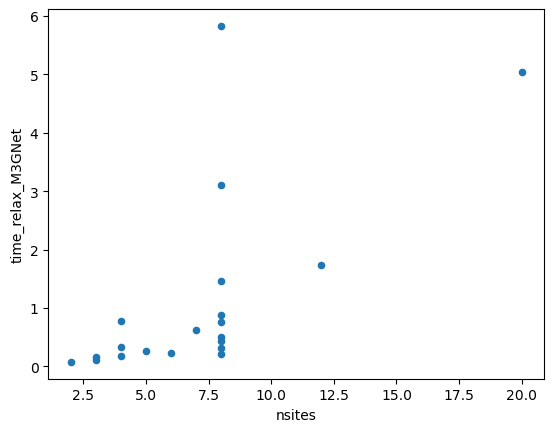

In [ ]:
ax = df_preds.plot(x="nsites", y="time_relax_M3GNet", kind="scatter")

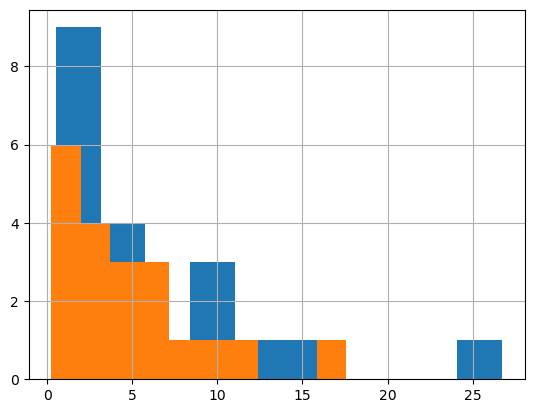

In [ ]:
ax = df_preds["time_total_M3GNet"].hist()
ax = df_preds["time_total_CHGNet"].hist()